# Ensaio de robustez - teste de ruído branco
## Grupo 2 - Trabalho de Conclusão de Curso
### - Bruno Uchôa Brandão e Silva - 12412440
### - Rayan Luz Ralile - 12412502

===============================================================================

### Passo 1: carregamento das bibliotecas usadas no programa

In [9]:
import numpy as np
import scipy.signal
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras.models import load_model
from keras.callbacks import Callback
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import MinMaxScaler
from IPython.core.display import HTML

### Passo 2: construção das funções auxiliares

In [10]:
# Funções de salvar e carregar objetos diversos - otimizar os passos de tratamento do dataset e treino
def salva_objeto(obj, file_path = "data.pickle"):
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)
        
def carrega_objeto(file_path = "data.pickle"):
    with open(file_path, 'rb') as file:
        obj = pickle.load(file)
    return obj

# Função que conta os pontos para emitir veridito de porte do navio e também
# faz o plot do gráfico em pizza com os pontos classificados

def create_plot(classificados, plot_name = "default.svg"):
   # Plotagem dos resultados
    classifications = classificados
    grande = 0
    pequeno = 0
    for classif in classifications:
        if classif == 'Navio Grande Porte' or classif == 'Grande Porte' or classif == 0:
            grande += 1
        if classif == 'Navio Pequeno Porte' or classif == 'Pequeno Porte' or classif == 1:
            pequeno += 1
    # plotagem da pizza
    labels = ['Navio Grande Porte', 'Navio Pequeno Porte']
    sizes = [grande, pequeno]

    colors = ['#ff9999','#66b3ff']


    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

    # Círculo branco central pra fazer a cara da pizza
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)


    ax1.axis('equal')  
    plt.tight_layout()


    plt.savefig("output.png", format='png')
    plt.savefig(plot_name, format='svg')

    # Agora o veredito:
    total = grande + pequeno
    if grande > pequeno and (grande/total) >= 0.6:
        return "Navio de Grande Porte"
    elif pequeno > grande and (pequeno/total) >= 0.6:
        return "Navio de Pequeno Porte"
    else:
        return "Inconclusivo"

# Teste de robustez.. ruídos brancos
## Parte 1 - classificação do 18.wav navio grande - ver como se comporta

In [11]:
# Lê os arquivos de áudio e processa a técnica PSD
def compute_psd(file_path, center_time):
    audio_data, original_sample_rate = librosa.load(file_path, sr=None)
    # original_sample_rate -> 48000Hz
    # Decima os dados de áudio
    audio_data = librosa.resample(audio_data, orig_sr=original_sample_rate, target_sr=4800)
    sample_rate = 4800
    
    
    # Computar o início e fim em torno do tempo de PMA em máx de 10 minutos
    start_sample = max(0, int((center_time - 5 * 60) * sample_rate))
    end_sample = min(len(audio_data), int((center_time + 5 * 60) * sample_rate))

    # Verifica se o tempo está completo
    if end_sample - start_sample != 10 * 60 * sample_rate:
        raise ValueError("Verificar argumento center_time - não efetivou intervalo por inteiro")


    audio_data = audio_data[start_sample:end_sample]
    # Reshape a matriz para as 600 amostras de 1 segundo cada
    chunks = audio_data.reshape(600, sample_rate)

    # Computar a densidade espectral de frequência usando o método Welch do SciPy
    psd_list = []
    for chunk in chunks:
        freqs, psd = scipy.signal.welch(chunk, sample_rate, nperseg=480, noverlap=240)
        # Seleciona as baixas frequências, de 10Hz a 2000Hz
        psd = psd[(freqs >= 10) & (freqs <= 2000)]
        psd_list.append(psd)
    return np.array(psd_list)

19/19 [==============================] - 0s 2ms/step
Grande Porte = 498
Pequeno Porte = 102
19/19 [==============================] - 0s 2ms/step
Grande Porte = 498
Pequeno Porte = 102
19/19 [==============================] - 0s 3ms/step
Grande Porte = 535
Pequeno Porte = 65
19/19 [==============================] - 0s 2ms/step
Grande Porte = 557
Pequeno Porte = 43


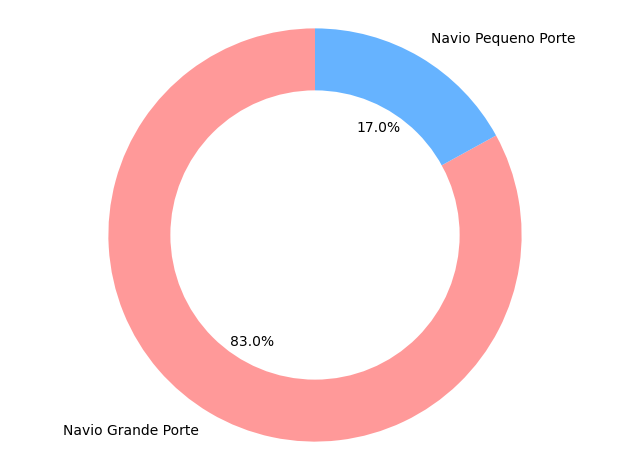

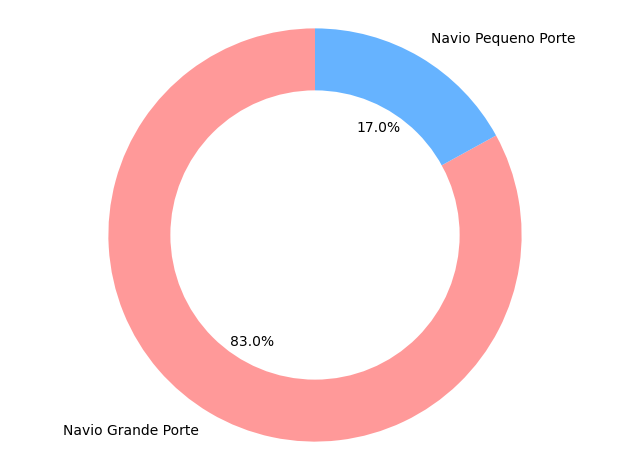

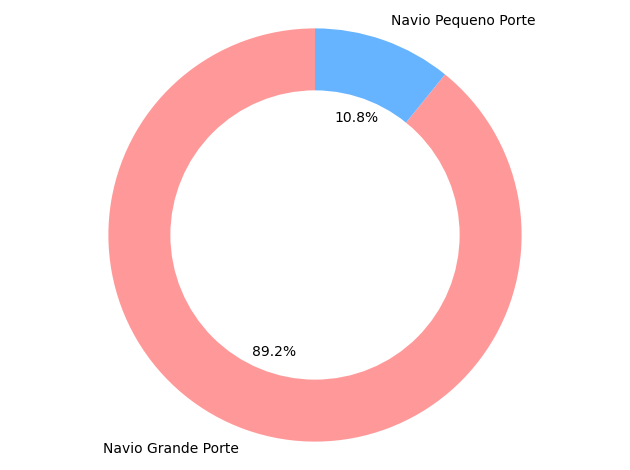

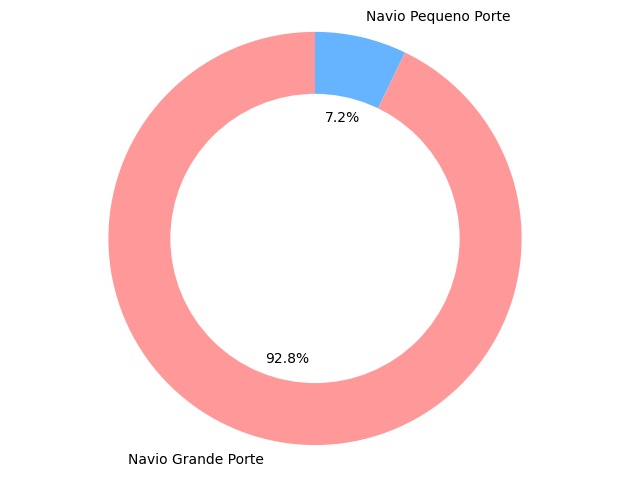

In [12]:
# Carregar o modelo de MLP do Keras
model = load_model("modelKeras.h5")

psdPuro = compute_psd('../ETAS_WAV/18.wav', 1800)
ruidoBranco001 = compute_psd('../ETAS_WAV/18R001.wav', 1800) #amplitude de noise em 0.01
ruidoBranco002 = compute_psd('../ETAS_WAV/18R002.wav', 1800) #amplitude de noise em 0.02
ruidoBranco003 = compute_psd('../ETAS_WAV/18R003.wav', 1800) #amplitude de noise em 0.03


psdPuro = np.array(psdPuro)
ruidoBranco001 = np.array(psdPuro)
ruidoBranco002 = np.array(ruidoBranco002)
ruidoBranco003 = np.array(ruidoBranco003)

scaler = MinMaxScaler()
psdPuro = scaler.fit_transform(psdPuro)
ruidoBranco001 = scaler.fit_transform(ruidoBranco001)
ruidoBranco002 = scaler.fit_transform(ruidoBranco002)
ruidoBranco003 = scaler.fit_transform(ruidoBranco003)

todos = []
todos.append(psdPuro)
todos.append(ruidoBranco001)
todos.append(ruidoBranco002)
todos.append(ruidoBranco003)

todos = np.array(todos)

caso = 0
for psdPuro in todos:
    # AQUI É O KERAS
    classifications = model.predict(psdPuro) # executa a predição
    predicted_labels = np.argmax(classifications, axis=1) # Pegar a classificação com maior probabilidade
    classifications = predicted_labels

    grande = 0
    pequeno = 0
    for classif in classifications:
        if classif == 'Navio Grande Porte' or classif == 0:
            grande += 1
        if classif == 'Navio Pequeno Porte' or classif == 1:
            pequeno += 1

    print(f'Grande Porte = {grande}')
    print(f'Pequeno Porte = {pequeno}')
    
    final_decision = create_plot(predicted_labels,f'Robustez - Caso {caso}.svg')
    
    caso += 1

## Conclusão:

* A medida que a intensidade de ruído branco aumenta no áudio, mais a rede MLP do Keras tende a classificá-lo como Navio Grande.